In [2]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
#Import from keras_preprocessing not from keras.preprocessing
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd
import numpy as np

def append_ext(fn):
    return fn+".jpg"

traindf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Part3_GroundTruth.csv',dtype=str)
testdf=pd.read_csv('D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Part3_GroundTruth.csv',dtype=str)
traindf['image_id']=traindf['image_id'].apply(append_ext)
testdf['image_id']=testdf['image_id'].apply(append_ext)

In [3]:
#create a label column
label=[0]*traindf.shape[0]
for i in range(traindf.shape[0]):
    if traindf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
traindf['label']=label    

label=[0]*testdf.shape[0]
for i in range(testdf.shape[0]):
    if testdf['melanoma'][i] == '1.0':
        label[i]='1'
    else:
        label[i]='0'
testdf['label']=label

In [4]:
X = traindf.loc[:,'image_id']
y = traindf.loc[:,'label']

In [16]:
from sklearn.model_selection import train_test_split
train_x, val_x, train_y, val_y = train_test_split(X, y, 
                                                  test_size = 0.25, 
                                                  random_state = 27, 
                                                  stratify=y)

In [17]:
df_train = pd.DataFrame(columns=['image_id','label'])
df_train['image_id'] = train_x
df_train['label'] = train_y

df_val= pd.DataFrame(columns=['image_id','label'])
df_val['image_id'] = val_x
df_val['label'] = val_y

In [35]:
from sklearn.utils import resample
non_melanoma = df_train[df_train['label']=='0']
melanoma = df_train[df_train['label']=='1']

# upsample minority -> some samples of melanoma will be duplicated
melanoma_upsampled = resample(melanoma,
                          replace=True, # sample with replacement
                          n_samples=len(non_melanoma), # match number in majority class
                          random_state=27) # reproducible results


# combine majority and upsampled minority alternately
# by reseting indexes, both dataframes now start at 0, 1, 2, etc. and are then sorted
df_train_upsampled = pd.concat([non_melanoma.reset_index(), melanoma_upsampled.reset_index()]).sort_index()
df_train_upsampled

,index,image_id,label
0,1864,ISIC_0014658.jpg,0
0,387,ISIC_0000482.jpg,1
1,689,ISIC_0010016.jpg,1
1,1324,ISIC_0012986.jpg,0
2,1078,ISIC_0012182.jpg,0
...,...,...,...
1217,1055,ISIC_0012102.jpg,0
1218,1361,ISIC_0013079.jpg,1
1218,658,ISIC_0009963.jpg,0
1219,1996,ISIC_0015233.jpg,0


In [19]:
#uncomment according to the architecture being used
# IMG_SIZE = 224 #B0
# IMG_SIZE = 240 #B1
# IMG_SIZE = 260 #B2
IMG_SIZE = 300 #B3
# IMG_SIZE = 380 #B4
# IMG_SIZE = 456 #B5
# IMG_SIZE = 528 #B6
# IMG_SIZE = 600 #B7

In [20]:
train_datagen=ImageDataGenerator(rotation_range=5,  # rotation
                                 width_shift_range=0.2,  # horizontal shift
                                 zoom_range=0.2,  # zoom
                                 horizontal_flip=True,  # horizontal flip
                                 brightness_range=[0.2,0.8] # brightness
                                )  


train_generator=train_datagen.flow_from_dataframe(dataframe=df_train_upsampled,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=False,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

valid_datagen=ImageDataGenerator()
valid_generator=valid_datagen.flow_from_dataframe(dataframe=df_val,
                                            directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Training_Data\\',
                                            x_col='image_id',
                                            y_col='label',
                                            batch_size=16,
                                            seed=42,
                                            shuffle=True,
                                            class_mode='binary',
                                            target_size=(IMG_SIZE,IMG_SIZE)
                                           )

test_datagen=ImageDataGenerator()#rescale=1./255.)
test_generator=test_datagen.flow_from_dataframe(dataframe=testdf,
                                                directory='D:\\UNI\\5º Ano - 2º Semestre - 2020-2021 - TESE\\Dataset\\ISIC-2017_Test_v2_Data\\',
                                                x_col='image_id',
                                                y_col=None,
                                                batch_size=30,
                                                seed=40,
                                                shuffle=False,
                                                class_mode=None,
                                                target_size=(IMG_SIZE,IMG_SIZE)
                                               )

Found 2440 validated image filenames belonging to 2 classes.
Found 500 validated image filenames belonging to 2 classes.
Found 600 validated image filenames.


In [21]:
from tensorflow.keras.applications import EfficientNetB3
# Create the base model from the pre-trained model EfficientNet
base_model = EfficientNetB3(include_top=False, weights="imagenet")

In [22]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

NUM_CLASSES=1
inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = inputs
model = EfficientNetB3(include_top=False, input_tensor=x, weights="imagenet")

# Freeze the pretrained weights
model.trainable = False

# Rebuild top
x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
x = layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
#x = layers.Dense(1024)(x)
outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred")(x)

# Compile
model = tf.keras.Model(inputs, outputs, name="EfficientNet")
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "EfficientNet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 300, 300, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 300, 300, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 301, 301, 3)  0           normalization_4[0][0]            
_______________________________________________________________________________________

In [23]:
#how this model performs on this data before fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

31/31 [==============================] - 116s 4s/step - loss: 0.7733 - accuracy: 0.3682


[0.7864139676094055, 0.3629032373428345]

In [24]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size

model.fit(train_generator,
          epochs=15,
          validation_data=valid_generator,
          verbose=1
         )

Epoch 1/15
153/153 [==============================] - 767s 5s/step - loss: 0.7028 - accuracy: 0.6242 - val_loss: 0.7476 - val_accuracy: 0.4680
Epoch 2/15
153/153 [==============================] - 741s 5s/step - loss: 0.6316 - accuracy: 0.6648 - val_loss: 0.6135 - val_accuracy: 0.6280
Epoch 3/15
153/153 [==============================] - 750s 5s/step - loss: 0.5760 - accuracy: 0.7012 - val_loss: 0.6385 - val_accuracy: 0.6560
Epoch 4/15
153/153 [==============================] - 737s 5s/step - loss: 0.5588 - accuracy: 0.7115 - val_loss: 0.6443 - val_accuracy: 0.6620
Epoch 5/15
153/153 [==============================] - 726s 5s/step - loss: 0.5486 - accuracy: 0.7287 - val_loss: 0.5434 - val_accuracy: 0.7280
Epoch 6/15
153/153 [==============================] - 727s 5s/step - loss: 0.5383 - accuracy: 0.7385 - val_loss: 0.6613 - val_accuracy: 0.6620
Epoch 7/15
153/153 [==============================] - 734s 5s/step - loss: 0.5250 - accuracy: 0.7402 - val_loss: 0.6177 - val_accuracy: 0.6880

In [25]:
#how this model performs after fitting
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
model.evaluate(valid_generator,
               steps=STEP_SIZE_VALID)

31/31 [==============================] - 118s 4s/step - loss: 0.5386 - accuracy: 0.7238


[0.5385751128196716, 0.7237903475761414]

In [26]:
test_generator.reset()

STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
pred=model.predict(test_generator,
                   steps=STEP_SIZE_TEST,
                   verbose=1)

20/20 [==============================] - 318s 16s/step


In [27]:
labels_pred=np.where(pred > 0.5, 1, 0)

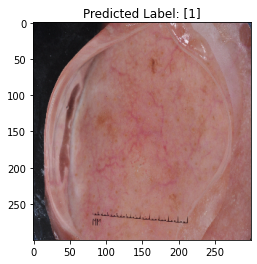

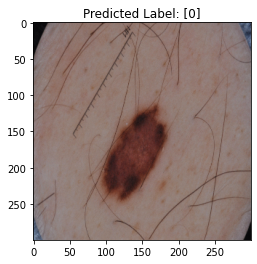

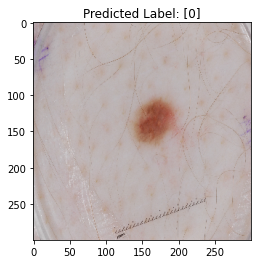

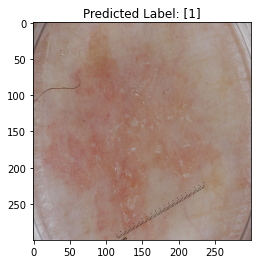

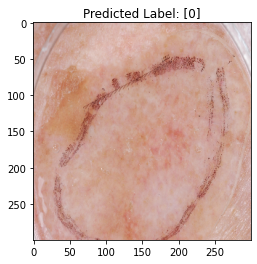

In [28]:
from keras.preprocessing import image
import matplotlib.pyplot as plt
x = test_generator.next() #this unpacks the ImageDataGenerator which is composed by x(image) and y(label). In the case of test, there are not labels
for i in range(5):
    image = x[i]
    plt.title('Predicted Label: ' + str(labels_pred[i]))
    plt.imshow(image.astype(np.uint8))
    plt.show()

In [29]:
model.save("EfficientNetB3_sigmoid.h5")
print("Saved model to disk")

# load model
# model = load_model('model.h5')
# model.summary()

Saved model to disk


In [30]:
import sklearn
confusion_matrix=sklearn.metrics.confusion_matrix(testdf['label'].astype(int).to_numpy(), labels_pred)

print('Confusion Matrix: \n' + str(confusion_matrix))

Confusion Matrix: 
[[372 111]
 [ 58  59]]


AUC Score: 0.6372299198386154


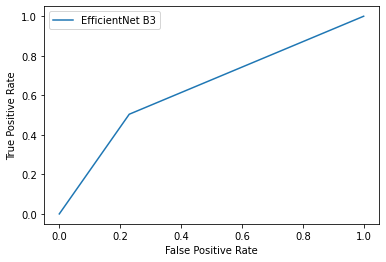

In [31]:
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr, tpr, threshold = roc_curve(testdf['label'].astype(int).to_numpy(),labels_pred)
roc_auc = metrics.auc(fpr, tpr)
print('AUC Score: ' + str(roc_auc))

# plot the roc curve for the model
plt.plot(fpr, tpr, linestyle='-', label='EfficientNet B3')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [34]:
jac=sklearn.metrics.jaccard_score(testdf['label'].astype(int).to_numpy(), labels_pred)
print('Jaccard Score: ' + str(jac))

Jaccard Score: 0.25877192982456143
